<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4: Modelling of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

## Check PyCaret Version

In [1]:
from pycaret.utils import version

In [2]:
version()

'2.3.6'

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dftorisv2.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


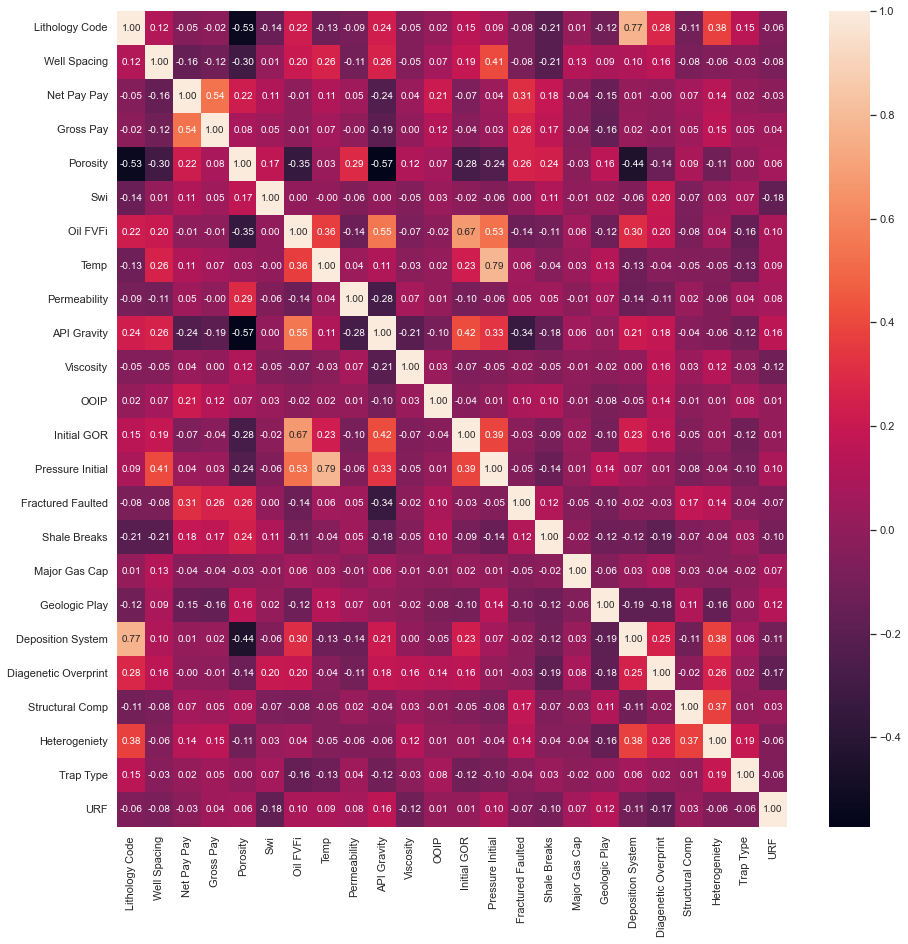

In [6]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. There was no highly correlated values

##### Convert to float - to ensure it is a numerical feature

In [7]:
df_drop = df.copy()
df_drop = df_drop.astype(float)

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

449
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lithology Code        449 non-null    float64
 1   Well Spacing          449 non-null    float64
 2   Net Pay Pay           449 non-null    float64
 3   Gross Pay             449 non-null    float64
 4   Porosity              449 non-null    float64
 5   Swi                   449 non-null    float64
 6   Oil FVFi              449 non-null    float64
 7   Temp                  449 non-null    float64
 8   Permeability          449 non-null    float64
 9   API Gravity           449 non-null    float64
 10  Viscosity             449 non-null    float64
 11  OOIP                  449 non-null    float64
 12  Initial GOR           449 non-null    float64
 13  Pressure Initial      449 non-null    float64
 14  Fractured Faulted     449 non-null    float64
 15  Shale Breaks       

Final Data set has 450 rows and 24 columns.

### Train, Validation, and Test Split

In [8]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(df_drop))<0.8

raw_train_validate_set = df_drop[msk]
raw_test_set = df_drop[~msk]

print(raw_train_validate_set.shape)
print(raw_test_set.shape)

(364, 24)
(85, 24)


In [9]:
raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)
raw_test_set.to_excel(r'BlindTest_SSOIL.xlsx', index = False, header=True)

We split the data set 80-20 into a "train-validate" set and a "test" set. The test set is external asn will never be seen by the model.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [10]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


In [12]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = 'URF'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            transformation = True,
            ignore_low_variance=True,
            remove_outliers = True, outliers_threshold = 0.1,
            remove_multicollinearity = True, multicollinearity_threshold = 0.7,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,URF
2,Original Data,"(449, 24)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(282, 18)"


In [13]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0950,0.0154,0.1227,0.0841,0.0904,0.3603,0.0310
br,Bayesian Ridge,0.0962,0.0154,0.1232,0.0820,0.0908,0.3723,0.0040
rf,Random Forest Regressor,0.0958,0.0157,0.1242,0.0655,0.0917,0.3719,0.0390
ridge,Ridge Regression,0.0979,0.0157,0.1242,0.0587,0.0918,0.3724,0.0040
lr,Linear Regression,0.0980,0.0157,0.1243,0.0570,0.0918,0.3726,0.3900
lar,Least Angle Regression,0.0980,0.0157,0.1243,0.0570,0.0918,0.3726,0.0040
huber,Huber Regressor,0.0977,0.0158,0.1246,0.0506,0.0921,0.3678,0.0040
knn,K Neighbors Regressor,0.0977,0.0164,0.1273,0.0166,0.0934,0.3536,0.0050
catboost,CatBoost Regressor,0.0964,0.0163,0.1266,0.0162,0.0934,0.3700,0.4720
lasso,Lasso Regression,0.1053,0.0174,0.1308,-0.0193,0.0962,0.4045,0.2150


In [14]:
top3_fold_5 = compare_models(include=['rf', 'catboost', 'knn'], fold = 5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0958,0.0155,0.1241,0.1013,0.0918,0.3725,0.0520
catboost,CatBoost Regressor,0.0969,0.0162,0.1270,0.0632,0.0937,0.3678,0.3920
knn,K Neighbors Regressor,0.0988,0.0164,0.1279,0.0435,0.0939,0.3567,0.0060


In [15]:
top3 = compare_models(include=['rf', 'catboost', 'knn'], fold = 10, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0958,0.0157,0.1242,0.0655,0.0917,0.3719,0.0400
catboost,CatBoost Regressor,0.0964,0.0163,0.1266,0.0162,0.0934,0.3700,0.4260
knn,K Neighbors Regressor,0.0977,0.0164,0.1273,0.0166,0.0934,0.3536,0.0050


There is a performance improvement in going from 5 folds to 10 folds for all 3 models. To keep computation time reasonable, folds is kept at 10.

## 2. Plot each Model and Check Features

##### Random Forest (RFR)

In [16]:
rfr = create_model('rf')
rfr_results = pull()

rfr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(rfr.feature_importances_)}).sort_values(by='Value', ascending=False)
rfr_feature_imp.to_csv('Feature_importance_RFR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0757,0.0091,0.0956,-0.1306,0.0722,0.2783
1,0.1168,0.0199,0.1411,0.1817,0.1069,0.5418
2,0.0933,0.0160,0.1264,0.0228,0.0920,0.3429
3,0.1195,0.0246,0.1569,-0.1516,0.1178,0.5814
4,0.0839,0.0127,0.1128,0.1185,0.0813,0.2646
5,0.1085,0.0180,0.1343,-0.1106,0.0984,0.3624
6,0.0991,0.0170,0.1305,0.2027,0.0957,0.3876
7,0.0755,0.0094,0.0970,0.3514,0.0730,0.2873
8,0.0901,0.0148,0.1219,0.2436,0.0883,0.3545
9,0.0951,0.0156,0.1249,-0.0731,0.0916,0.3179


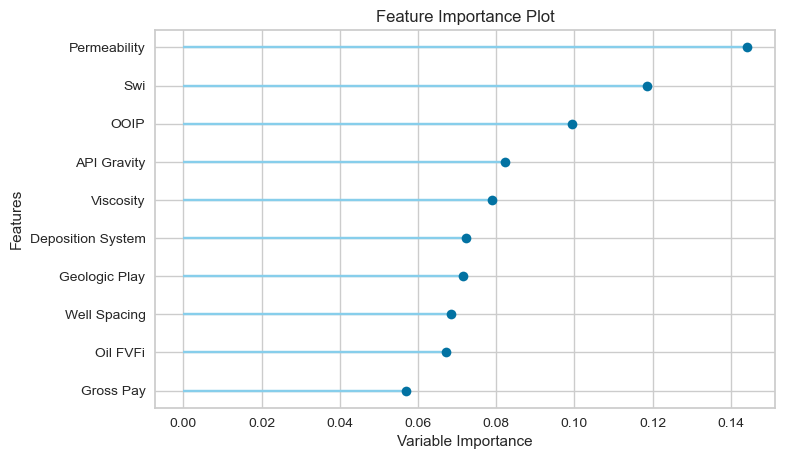

In [17]:
plot_model(rfr, plot = 'feature')

##### Catboost Regressor (catboost)

In [18]:
cb = create_model('catboost')
cb_results = pull()
#print(gbr_results)

cb_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(cb.feature_importances_)}).sort_values(by='Value', ascending=False)
cb_feature_imp.to_csv('Feature_importance_CatBoost.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0780,0.0108,0.1038,-0.3321,0.0782,0.2905
1,0.1157,0.0202,0.1422,0.1694,0.1076,0.5433
2,0.0944,0.0174,0.1317,-0.0616,0.0961,0.3491
3,0.1241,0.0268,0.1637,-0.2533,0.1230,0.5945
4,0.0888,0.0140,0.1184,0.0303,0.0852,0.2761
5,0.1100,0.0177,0.1331,-0.0905,0.0975,0.3667
6,0.0926,0.0152,0.1233,0.2889,0.0897,0.3502
7,0.0789,0.0108,0.1038,0.2569,0.0775,0.2805
8,0.0868,0.0138,0.1177,0.2947,0.0847,0.3227
9,0.0946,0.0166,0.1288,-0.1402,0.0947,0.3260


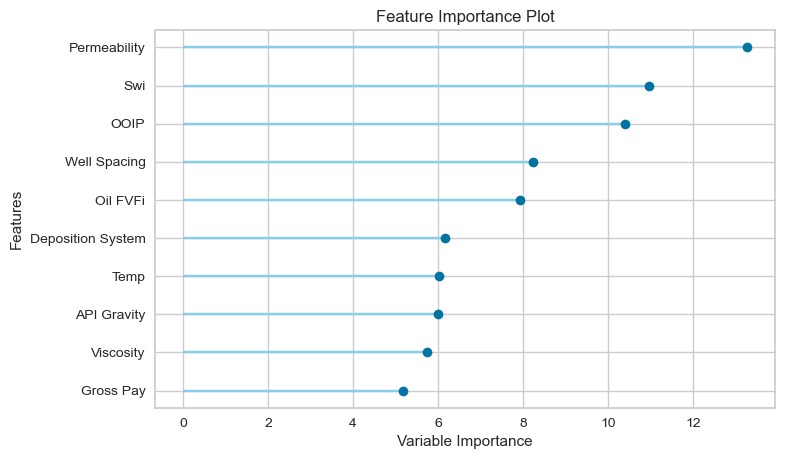

In [19]:
plot_model(cb, plot = 'feature')

##### Gradient Boost Regressor (gbr)

In [22]:
gbr = create_model('gbr')
gbr_results = pull()
#print(cb_results)

gbr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(gbr.feature_importances_)}).sort_values(by='Value', ascending=False)
gbr_feature_imp.to_csv('Feature_importance_GBR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0920,0.0134,0.1156,-0.6519,0.0860,0.3297
1,0.1236,0.0232,0.1524,0.0452,0.1146,0.5777
2,0.1021,0.0203,0.1425,-0.2425,0.1046,0.3824
3,0.1224,0.0275,0.1657,-0.2844,0.1244,0.5776
4,0.0957,0.0160,0.1266,-0.1094,0.0922,0.2921
5,0.1160,0.0186,0.1363,-0.1448,0.0997,0.3841
6,0.0844,0.0119,0.1090,0.4437,0.0800,0.3213
7,0.0816,0.0126,0.1122,0.1323,0.0843,0.3038
8,0.0870,0.0131,0.1146,0.3306,0.0824,0.3004
9,0.1047,0.0182,0.1350,-0.2529,0.0987,0.3316


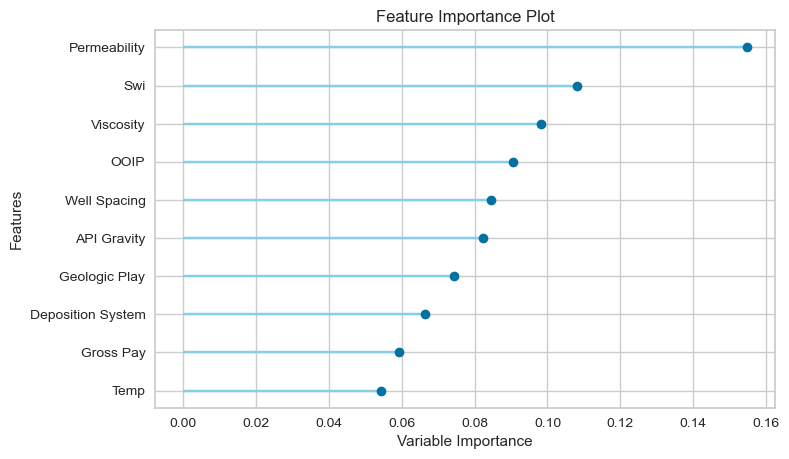

In [23]:
# Given the sheer number of variables, will only plot the first 10
# 'feature_all' will plot everything
plot_model(gbr, plot = 'feature')

### KNN Model - note that it does not support feature importance

In [25]:
knn = create_model('knn')
knn_results = pull()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0757,0.0093,0.0962,-0.1442,0.0726,0.2688
1,0.1125,0.0184,0.1357,0.2439,0.1018,0.4880
2,0.0892,0.0154,0.1242,0.0560,0.0896,0.3047
3,0.1129,0.0202,0.1422,0.0541,0.1052,0.4943
4,0.1031,0.0179,0.1338,-0.2392,0.0966,0.3091
5,0.1102,0.0181,0.1345,-0.1132,0.0987,0.3670
6,0.1054,0.0212,0.1455,0.0091,0.1057,0.3832
7,0.0860,0.0109,0.1042,0.2513,0.0779,0.2989
8,0.0937,0.0185,0.1359,0.0599,0.0971,0.3361
9,0.0881,0.0147,0.1212,-0.0112,0.0890,0.2862


## 3a. Testing for Optimisation - Not necessary to run
-----------------------------------------------------------------------------------

One of the important parameters in the hyperparameters is the number of iterations over which the K fold cross validation is done. 

2 checks are done for this. The first scenario is over the range(0, 1000, 50). The optimisation ran overnight and showed that the ML algorithm did not see much improvement past 50.

In [26]:
# elapsed = []
# MAE_mean_iter = []
# MSE_mean_iter = []
# RMSE_mean_iter = []

# # The output from the (0, 1000, 50) is saved; there is no need to run this again. 
# # Line has been modified just so the code can run.
# for i in range(0, 51, 50):
#     start = time.time()
#     if i == 0:
#         i += 1    
#     tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
#     #print(tuned_cb)
#     MAE_mean_iter.append(pull()['MAE']['Mean'])
#     MSE_mean_iter.append(pull()['MSE']['Mean'])
#     RMSE_mean_iter.append(pull()['RMSE']['Mean'])
#     elapsed.append((time.time() - start))

# MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
# MAE_Mean.index.name = 'Elapsed Time'

# MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
# MSE_Mean.index.name = 'Elapsed Time'

# RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
# RMSE_Mean.index.name = 'Elapsed Time'

# res_50_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

# print(res_50_iter)

In [27]:
# b = sns.lineplot(data=res_50_iter)
# b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
# b.set_xlabel("Elapsed Time",fontsize=20)
# b.set_ylabel("Error",fontsize=20)
# #b.set_yscale('log')
# b.tick_params(labelsize=18)

In [28]:
#res.to_csv('Run_Catboost_1000_Itr.csv')

In [29]:
# elapsed = []
# MAE_mean_iter = []
# MSE_mean_iter = []
# RMSE_mean_iter = []

# # This was run at (1, 51, 1) to get increments of 1
# # Right now, this is changed to (1, 51, 50) to allow the code to run efficiently
# for i in range(1, 51, 50):
#     start = time.time()
#     tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
#     MAE_mean_iter.append(pull()['MAE']['Mean'])
#     MSE_mean_iter.append(pull()['MSE']['Mean'])
#     RMSE_mean_iter.append(pull()['RMSE']['Mean'])
#     elapsed.append((time.time() - start))

# MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
# MAE_Mean.index.name = 'Elapsed Time'

# MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
# MSE_Mean.index.name = 'Elapsed Time'

# RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
# RMSE_Mean.index.name = 'Elapsed Time'

# res_1_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

# print(res_1_iter)

# res_1_iter.to_csv('Run_Catboost_50_Itr.csv')

In [30]:
# b = sns.lineplot(data=res_1_iter)
# b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
# b.set_xlabel("Elapsed Time",fontsize=20)
# b.set_ylabel("Error",fontsize=20)
# #b.set_yscale('log')
# b.tick_params(labelsize=18)

In [31]:
# tuned_cb3 = tune_model(cb, optimize = 'RMSE', n_iter = 10)

In [32]:
# plot_model(tuned_cb3, plot = 'parameter')

##### Gradient Boosting Regression

In [33]:
# gbr = create_model('gbr')
# print(gbr)

In [34]:
# tuned_gbr = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
# print(tuned_gbr)

----------------------------------------------------------------------------------------------------------------------------

## 3. Optimisation

### a. Tune the Model

The earlier experiments allow one to determine which model performs efficiently, and the tuning needed to arrive at the answer. Here, we will create the 3 specific models , which we will than blend, and than finally produce a "tuned" blended model based on earlier optimised parameters

from pycaret.distributions import UniformDistribution, CategoricalDistribution

catboost_param_dists = {
    'iterations': CategoricalDistribution([500,100,300]),
    'colsample_bylevel': UniformDistribution(0.5, 1.0),
    'random_strength': CategoricalDistribution([0,0.1,0.2,1,10]),
    'max_depth' : CategoricalDistribution([5,6,7,8,9])
}

In [36]:
tuned_models = []

In [37]:
rf = create_model('rf', fold = 10)
rf = tune_model(rf, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0704,0.0093,0.0963,-0.1453,0.0726,0.2584
1,0.1071,0.0156,0.1249,0.3585,0.0949,0.4789
2,0.0880,0.0146,0.1208,0.1078,0.0876,0.3227
3,0.1141,0.0238,0.1543,-0.1131,0.1157,0.5586
4,0.0860,0.0137,0.1171,0.0515,0.0846,0.2699
5,0.1055,0.0170,0.1302,-0.0445,0.0953,0.3515
6,0.0965,0.0165,0.1284,0.2282,0.0938,0.3715
7,0.0735,0.0094,0.0968,0.3545,0.0724,0.2665
8,0.0885,0.0157,0.1255,0.1982,0.0907,0.3531
9,0.0895,0.0149,0.1219,-0.0225,0.0891,0.2887


In [38]:
cb = create_model('catboost', fold = 10)
cb = tune_model(cb, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True,
                #search_library = "optuna", 
                #search_library = "tune-sklearn", 
                #search_algorithm="bayesian",
                #search_algorithm="hyperopt",
                #custom_grid = catboost_param_dists ,
                #early_stopping = "asha",
                #early_stopping_max_iters = 10,
                #return_tuner = False ,   
               )

tuned_models.append(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0761,0.0093,0.0965,-0.1512,0.0728,0.2774
1,0.1196,0.0194,0.1392,0.2033,0.1050,0.5354
2,0.0914,0.0148,0.1217,0.0937,0.0884,0.3356
3,0.1215,0.0234,0.1529,-0.0935,0.1145,0.5907
4,0.0866,0.0134,0.1159,0.0696,0.0840,0.2805
5,0.1078,0.0166,0.1289,-0.0224,0.0945,0.3671
6,0.0975,0.0170,0.1305,0.2028,0.0950,0.3732
7,0.0862,0.0107,0.1035,0.2612,0.0776,0.3196
8,0.0931,0.0162,0.1274,0.1731,0.0922,0.3832
9,0.0896,0.0140,0.1183,0.0381,0.0864,0.2930


In [39]:
knn = create_model('knn', fold = 10)
knn = tune_model(knn, 
                 optimize = 'RMSE', 
                 n_iter = 50, 
                 choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0719,0.0080,0.0896,0.0074,0.0679,0.2604
1,0.1189,0.0189,0.1376,0.2225,0.1036,0.5201
2,0.0855,0.0132,0.1150,0.1906,0.0833,0.3082
3,0.1088,0.0197,0.1402,0.0811,0.1048,0.5338
4,0.0860,0.0129,0.1138,0.1038,0.0820,0.2709
5,0.1119,0.0178,0.1332,-0.0932,0.0977,0.3768
6,0.1020,0.0183,0.1353,0.1432,0.0979,0.3796
7,0.0850,0.0097,0.0986,0.3300,0.0738,0.3079
8,0.0892,0.0156,0.1248,0.2067,0.0896,0.3520
9,0.0893,0.0131,0.1143,0.1016,0.0839,0.2950


### b. Ensemble the Model

pycaret.regression.ensemble_model(estimator, method: str = 'Bagging', fold: Optional[Union[int, Any]] = None, n_estimators: int = 10, round: int = 4, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [40]:
prediction_model = []

In [41]:
tuned_bagged_rf = ensemble_model(estimator = rf, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0716,0.0084,0.0919,-0.0430,0.0695,0.2620
1,0.1159,0.0178,0.1334,0.2686,0.1003,0.5009
2,0.0886,0.0149,0.1219,0.0904,0.0884,0.3240
3,0.1148,0.0222,0.1488,-0.0358,0.1113,0.5595
4,0.0832,0.0135,0.1161,0.0665,0.0838,0.2636
5,0.1074,0.0170,0.1302,-0.0446,0.0953,0.3598
6,0.0988,0.0173,0.1314,0.1924,0.0954,0.3732
7,0.0785,0.0096,0.0979,0.3394,0.0733,0.2872
8,0.0897,0.0158,0.1257,0.1953,0.0903,0.3504
9,0.0882,0.0139,0.1179,0.0434,0.0859,0.2811


In [42]:
tuned_boosted_rf = ensemble_model(estimator = rf, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0779,0.0104,0.1021,-0.2891,0.0771,0.2909
1,0.1244,0.0214,0.1462,0.1217,0.1102,0.5676
2,0.0990,0.0168,0.1295,-0.0257,0.0943,0.3565
3,0.1223,0.0234,0.1531,-0.0962,0.1148,0.5957
4,0.0816,0.0127,0.1129,0.1179,0.0817,0.2673
5,0.1102,0.0176,0.1325,-0.0809,0.0970,0.3713
6,0.0945,0.0147,0.1211,0.3142,0.0882,0.3549
7,0.0786,0.0098,0.0988,0.3271,0.0738,0.2895
8,0.0946,0.0161,0.1268,0.1808,0.0920,0.3857
9,0.0938,0.0161,0.1269,-0.1068,0.0929,0.3125


In [43]:
tuned_bagged_cb = ensemble_model(estimator = cb, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0713,0.0084,0.0916,-0.0382,0.0694,0.2635
1,0.1219,0.0197,0.1404,0.1900,0.1054,0.5285
2,0.0904,0.0149,0.1220,0.0891,0.0886,0.3342
3,0.1177,0.0221,0.1487,-0.0335,0.1114,0.5774
4,0.0839,0.0130,0.1140,0.0997,0.0825,0.2714
5,0.1068,0.0164,0.1281,-0.0112,0.0940,0.3641
6,0.0981,0.0171,0.1307,0.2002,0.0950,0.3739
7,0.0852,0.0107,0.1033,0.2645,0.0774,0.3162
8,0.0905,0.0163,0.1277,0.1698,0.0921,0.3691
9,0.0898,0.0141,0.1187,0.0309,0.0867,0.2929


In [44]:
tuned_boosted_cb = ensemble_model(estimator = cb, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0781,0.0103,0.1013,-0.2694,0.0766,0.2959
1,0.1296,0.0230,0.1517,0.0550,0.1140,0.5845
2,0.0960,0.0161,0.1269,0.0146,0.0924,0.3552
3,0.1226,0.0235,0.1534,-0.1009,0.1148,0.5906
4,0.0845,0.0126,0.1122,0.1286,0.0816,0.2844
5,0.1084,0.0165,0.1283,-0.0140,0.0942,0.3736
6,0.0961,0.0152,0.1233,0.2892,0.0900,0.3681
7,0.0891,0.0116,0.1079,0.1980,0.0807,0.3302
8,0.0879,0.0148,0.1216,0.2470,0.0881,0.3690
9,0.0904,0.0143,0.1196,0.0158,0.0873,0.2916


In [45]:
tuned_bagged_knn = ensemble_model(estimator = knn, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0713,0.0079,0.0890,0.0201,0.0674,0.2584
1,0.1184,0.0187,0.1367,0.2325,0.1028,0.5144
2,0.0860,0.0137,0.1171,0.1616,0.0847,0.3084
3,0.1082,0.0196,0.1399,0.0848,0.1045,0.5317
4,0.0866,0.0132,0.1151,0.0835,0.0829,0.2711
5,0.1113,0.0177,0.1330,-0.0896,0.0975,0.3721
6,0.1025,0.0189,0.1376,0.1144,0.0995,0.3813
7,0.0852,0.0099,0.0995,0.3175,0.0746,0.3098
8,0.0897,0.0161,0.1268,0.1807,0.0910,0.3540
9,0.0885,0.0130,0.1141,0.1044,0.0837,0.2926


In [46]:
tuned_boosted_knn = ensemble_model(estimator = knn, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0815,0.0100,0.1002,-0.2418,0.0757,0.2965
1,0.1142,0.0176,0.1325,0.2786,0.1004,0.5082
2,0.0917,0.0137,0.1172,0.1595,0.0853,0.3343
3,0.1152,0.0217,0.1473,-0.0143,0.1097,0.5488
4,0.0879,0.0130,0.1141,0.0982,0.0824,0.2831
5,0.1143,0.0174,0.1320,-0.0727,0.0967,0.3843
6,0.0981,0.0167,0.1291,0.2200,0.0938,0.3738
7,0.0862,0.0106,0.1031,0.2669,0.0771,0.3145
8,0.0831,0.0134,0.1156,0.3196,0.0830,0.3292
9,0.0930,0.0154,0.1241,-0.0600,0.0914,0.3190


### c. Blending all Models

pycaret.regression.blend_models(
estimator_list: list, fold: Optional[Union[int, Any]] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Optional[List[float]] = None, fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False )

In [47]:
blend_5_soft = blend_models(estimator_list = tuned_models, fold=5, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_5_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0931,0.0129,0.1137,0.2141,0.0859,0.3821
1,0.1032,0.0181,0.1344,0.0632,0.0995,0.4493
2,0.0954,0.0147,0.1212,0.0498,0.0882,0.3119
3,0.0904,0.0134,0.1159,0.2525,0.0853,0.3392
4,0.0883,0.0145,0.1203,0.1561,0.0871,0.3170
Mean,0.0941,0.0147,0.1211,0.1471,0.0892,0.3599
SD,0.0051,0.0018,0.0072,0.0802,0.0053,0.0511


In [48]:
blend_10_soft = blend_models(estimator_list = tuned_models, fold=10, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_10_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0719,0.0086,0.0929,-0.0667,0.0702,0.2626
1,0.1149,0.0178,0.1333,0.2703,0.1007,0.5107
2,0.0871,0.0140,0.1184,0.1428,0.0858,0.3186
3,0.1143,0.0219,0.1481,-0.0255,0.1109,0.5597
4,0.0846,0.0131,0.1144,0.0942,0.0826,0.2695
5,0.1069,0.0169,0.1300,-0.0403,0.0952,0.3609
6,0.0985,0.0171,0.1309,0.1987,0.0951,0.3743
7,0.0807,0.0096,0.0978,0.3409,0.0733,0.2951
8,0.0894,0.0156,0.1249,0.2050,0.0901,0.3601
9,0.0891,0.0137,0.1170,0.0589,0.0855,0.2910


### d. Stacking all Models

pycaret.regression.stack_models(estimator_list: list, meta_model=None, meta_model_fold: Optional[Union[int, Any]] = 5, fold: Optional[Union[int, Any]] = None, round: int = 4, restack: bool = True, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [49]:
stack_5 = stack_models(estimator_list = tuned_models, meta_model = rf, fold = 5, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0893,0.0123,0.1107,0.2548,0.0837,0.3627
1,0.1065,0.0201,0.1417,-0.0416,0.1051,0.4649
2,0.1003,0.0162,0.1271,-0.0451,0.0923,0.3196
3,0.0888,0.0131,0.1144,0.2719,0.0843,0.3321
4,0.0867,0.0145,0.1206,0.1510,0.0874,0.3030
Mean,0.0943,0.0152,0.1229,0.1182,0.0906,0.3564
SD,0.0077,0.0028,0.0109,0.1382,0.0079,0.0577


In [50]:
stack_10 = stack_models(estimator_list = tuned_models, meta_model = rf, fold = 10, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0745,0.0093,0.0963,-0.1468,0.0722,0.2608
1,0.1012,0.0151,0.1229,0.3788,0.0939,0.4703
2,0.0894,0.0146,0.1208,0.1079,0.0877,0.3190
3,0.1169,0.0239,0.1547,-0.1185,0.1158,0.5618
4,0.0874,0.0137,0.1172,0.0498,0.0841,0.2687
5,0.1052,0.0165,0.1283,-0.0141,0.0937,0.3470
6,0.0923,0.0157,0.1252,0.2669,0.0906,0.3434
7,0.0723,0.0083,0.0913,0.4254,0.0683,0.2616
8,0.0929,0.0162,0.1273,0.1752,0.0919,0.3558
9,0.0841,0.0131,0.1146,0.0970,0.0830,0.2586


In [51]:
prediction_model

[BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       criterion='mae',
                                                       max_depth=9,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0001,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=10,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=60,
                   

In [52]:
for model in prediction_model:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0955,0.0146,0.1209,0.1370,0.0886,0.3605


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.254193
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.333924
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.346893
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.381032
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.322834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.339472
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.318677
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.370381
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.380131


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0947,0.0141,0.1188,0.1667,0.0871,0.3611


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.228380
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.330563
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.403006
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.348555
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.307266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.377055
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.350640
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.361434
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.381573


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0966,0.0147,0.1211,0.1339,0.0890,0.3750


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.273355
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.342198
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.349897
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.383649
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.320164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.344402
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.344649
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.379351
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.369109


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0945,0.0144,0.1200,0.1505,0.0881,0.3694


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.244776
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.346343
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.385818
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.387956
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.294952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.362096
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.356960
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.372018
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.366714


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1001,0.0154,0.1243,0.0881,0.0912,0.3818


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.263740
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.356845
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.351972
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.338394
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.323359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.351560
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.326852
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.390328
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.354685


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1031,0.0163,0.1276,0.0387,0.0938,0.3960


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.236959
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.359269
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.405977
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.350105
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.273630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.378190
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.329543
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.382901
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.355457


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0971,0.0149,0.1219,0.1226,0.0894,0.3689


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.252517
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.341089
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.349908
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.368564
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.311917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.345938
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.323783
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.363110
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.366011


KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1009,0.0157,0.1253,0.0739,0.0919,0.3838


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.262658
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.352162
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.356903
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.335824
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.310681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.354147
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.322705
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.386880
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.352227


KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1009,0.0157,0.1253,0.0739,0.0919,0.3838


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.262658
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.352162
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.356903
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.335824
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.310681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.354147
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.322705
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.386880
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.352227


StackingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.0941,0.0148,0.1215,0.1286,0.0888,0.3440


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.233750
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.337726
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.344445
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.342298
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.302457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.339602
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.291118
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.321588
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.402405


From the results above, the best models are 

1. blend_5_soft
2. stack_10
3. tuned_boosted_cb
4. tuned_boosted_rf

## 4. Save the Model

In [53]:
save_model(blend_5_soft, 'Blended_model_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                                                                     n_estimators=60,
                                                                     n_jobs=-1,
                                                                     oob_score=False,
                                                             

In [54]:
save_model(stack_10, 'Stacked_model_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                                                                          ccp_alpha=0.0,
                                                                          criterion='mae',
                                                                          max_depth=9,
                                              

In [55]:
save_model(tuned_boosted_cb, 'Boosted_cb_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                  Fix_multicollinearity(correlation_with_target_preference=None,
                                        correlation_with_target_threshold=0.0,
                                        target_variable='URF', threshold=0.7)),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
        

In [56]:
save_model(tuned_boosted_rf, 'Boosted_rf_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                                                                         max_depth=9,
                                                                         max_features='sqrt',
                                                                         max_leaf_nodes=None,
                                       

## 5. Finalise the model

In [57]:
final_blend = finalize_model(blend_5_soft)

In [58]:
final_stack = finalize_model(stack_10)

In [59]:
final_cb = finalize_model(tuned_boosted_cb)

In [60]:
final_rf = finalize_model(tuned_boosted_rf)

### Plots to analyse Model

In [61]:
model = final_blend
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0452,0.0033,0.0578,0.8027,0.0423,0.1730


,Well Spacing,Gross Pay,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,0.602711,-0.997380,1.342416,0.615049,-0.184962,-0.777062,0.917657,-0.391974,-0.073592,-0.530323,-1.150668,-0.067872,1.783713,-0.455652,-0.686846,-1.673975,0.0,0.0,0.250000,0.257105
1,1.402515,-1.041017,-0.189573,1.074563,0.301265,-0.279372,0.917657,-0.413451,-0.615333,5.219486,-1.154283,1.625201,-0.740646,-0.455652,-0.686846,-1.673975,0.0,1.0,0.504560,0.450866
2,-1.186079,0.794820,0.987307,0.949207,1.465668,-0.654778,-0.303106,-0.407896,-1.057891,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.380000,0.352758
3,-0.294680,-1.118747,-0.784482,0.628467,0.158020,-0.704353,0.058473,-0.376108,-0.615333,-0.530323,-1.168779,-0.859795,-0.740646,-0.455652,-0.686846,-1.673975,0.0,0.0,0.290000,0.340732
4,-1.344908,1.931956,-0.521203,-1.333851,-0.328036,1.276756,-1.408754,0.186547,1.946271,-0.530323,-0.005210,-0.041225,-0.740646,2.217926,1.694416,-0.414861,1.0,1.0,0.650000,0.479340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-1.263619,1.931956,0.617352,0.541186,0.685477,-0.172917,-0.519274,-0.362942,2.235092,-0.530323,0.008801,-0.041225,-0.740646,-0.455652,-0.686846,-0.414861,1.0,1.0,0.370000,0.356265
131,-1.344908,-0.005199,-1.102301,-1.333851,0.005136,1.902584,-2.366800,3.449037,2.154622,-0.530323,0.018079,0.217763,1.826869,2.127502,1.694416,-0.414861,0.0,0.0,0.060521,0.165119
132,-0.294680,-1.314870,0.227689,-0.845153,-0.328036,1.757420,-1.582771,2.186584,-1.069115,-0.530323,1.686849,-0.889504,-0.740646,-0.455652,-0.686846,-0.414861,1.0,0.0,0.274000,0.302048
133,-0.810540,-1.279495,-1.102301,-0.036777,-1.443602,-0.757408,1.404480,-0.328901,-1.105840,-0.530323,1.295368,-0.889504,-0.740646,-0.455652,-0.686846,1.153353,0.0,1.0,0.422148,0.394699


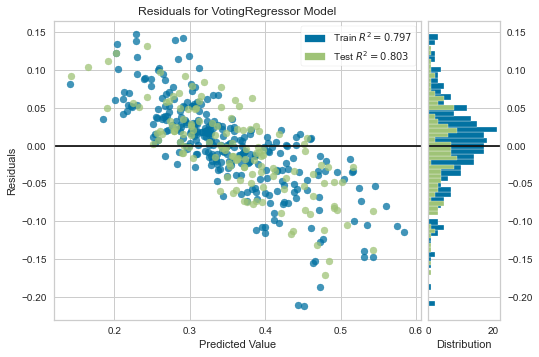

In [62]:
plot_model(model)

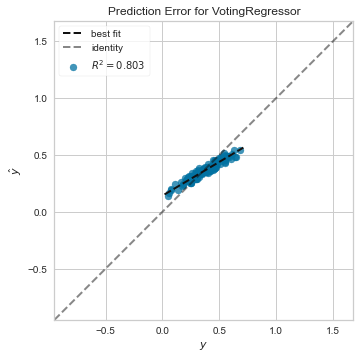

In [63]:
# Prediction Error 
plot_model(model, plot = 'error')

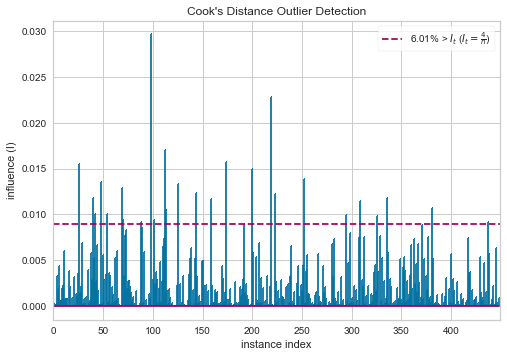

In [64]:
# Cooks Distance Plot
plot_model(model, plot='cooks')

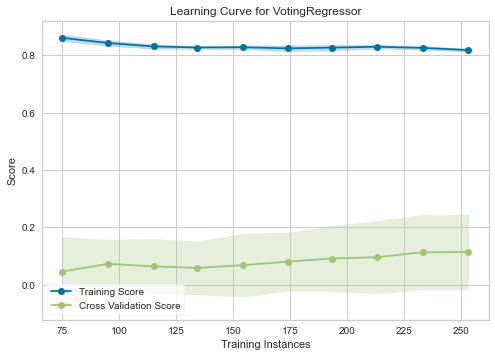

In [65]:
# Learning Curve
plot_model(model, plot='learning')

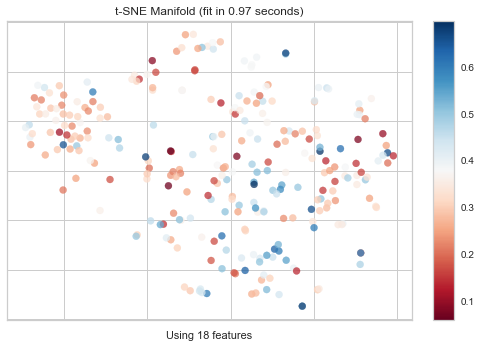

In [66]:
# Manifold Learning
plot_model(model, plot='manifold')

In [67]:
# Model Hyperparameter
plot_model(model, plot='parameter')

,Parameters
estimators,"[('rf', RandomForestRegressor(bootstrap=False,..."
n_jobs,-1
verbose,False
weights,None


## 6. Blind Test

In [68]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,20.0000,8.6,12.0,30.0,32.0,1.100,118,1200.0,17.0,...,1,0,0,2407,151,1,10,1,2,0.274000
1,1,10.0000,10.0,60.0,25.0,40.0,1.100,110,1500.0,34.0,...,0,1,0,2407,151,1,10,1,1,0.360000
2,1,20.0000,11.0,110.0,28.0,25.0,1.060,125,1500.0,20.0,...,0,1,1,2407,151,1,10,1,2,0.320000
3,1,10.0000,190.0,480.0,27.0,22.0,1.140,146,430.0,23.5,...,0,0,0,418,181,1,10,1,2,0.258000
4,1,2.3662,556.0,1500.0,25.5,20.0,1.311,190,58.0,27.7,...,0,1,0,414,181,1,30,3,2,0.309771


In [70]:
BlindPredict = predict_model(final_blend, data=dfblind, round=2)

In [71]:
BlindPredict

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF,Label
0,1,20.0000,8.6,12.0,30.0,32.0,1.100,118,1200.0,17.0,...,0,0,2407,151,1,10,1,2,0.274000,0.302048
1,1,10.0000,10.0,60.0,25.0,40.0,1.100,110,1500.0,34.0,...,1,0,2407,151,1,10,1,1,0.360000,0.408779
2,1,20.0000,11.0,110.0,28.0,25.0,1.060,125,1500.0,20.0,...,1,1,2407,151,1,10,1,2,0.320000,0.385504
3,1,10.0000,190.0,480.0,27.0,22.0,1.140,146,430.0,23.5,...,0,0,418,181,1,10,1,2,0.258000,0.329302
4,1,2.3662,556.0,1500.0,25.5,20.0,1.311,190,58.0,27.7,...,1,0,414,181,1,30,3,2,0.309771,0.358089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1,40.0000,40.0,520.0,14.7,21.0,1.700,140,34.0,47.0,...,0,1,704,110,1,10,1,1,0.470000,0.395405
81,1,10.0000,71.0,100.0,19.0,33.5,1.130,100,52.0,37.0,...,0,0,831,151,1,31,1,2,0.470000,0.427398
82,1,20.0000,150.0,250.0,10.3,10.0,1.126,165,20.0,34.0,...,0,0,825,110,1,31,1,2,0.450000,0.406115
83,1,20.0000,105.0,300.0,16.3,11.5,1.050,125,190.0,25.0,...,0,0,825,110,1,31,1,2,0.400000,0.398105


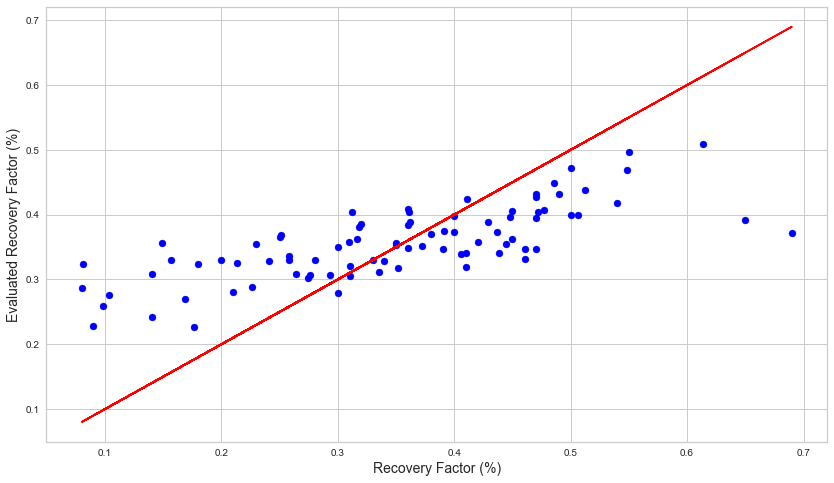

In [72]:
a = BlindPredict['URF']
b = BlindPredict['Label']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()

In [73]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 1988.906864643097 seconds
